Inverse problem solving

In [12]:
import matplotlib.pyplot as plt
from clspde.solution import lp as l
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

function_list = ['a', 'v']
variable_list = ['t','x']

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)


power = 6
params = {
        'n_dims': 2,
        'dim_sizes': np.array([8, 8]),
        'area_lims': np.array([[0,1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

# def alpha(x):
#     return x[1]**2

c = 1
def F(alpha, t):
    return ((c-t)*alpha)**2


sigma = 0.5

def prepare_model(border_weight, colloc_weight, connect_weights, c):
    sol = Solution(**params)

    w = 1
    k1 = connect_weights[0]
    k2 = connect_weights[1]


    colloc_left_operators = [lp('(d/dt) v + (d/dx)^2 v /2*sigma**2 + a * (d/dx) &v + &a * (d/dx) v'),
                            lp('(d/dx) v + 2*(c- t ) * a')]
    
    colloc_right_operators = [lp('-F( &a , t )'),
                            lp('0')]

    colloc_ops = [colloc_left_operators, colloc_right_operators]
        
    small = 1e-5

    def Bx(x):
        #border condition for x
        # return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))
        return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

    def BtI(x):
        #border condition Initial for t
        return int(x[0]==sol.area_lims[0,0])

    def BtT(x):
        #border condtition Terminal for t
        return int(x[0]==sol.area_lims[0,1])

    border_left_operators = [
        lp('Bx(x) * (d/dx) v'),
        lp('BtT(x) * v'),
        lp('Bx(x) * a'),
    ]
    border_right_operators = [
        lp('Bx(x)* 0'),
        lp('BtT(x) * 0'),
        lp('Bx(x)* 0'),
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = np.array([
                                [-1, 0.25], [-1, -0.25],
                                [-1, 0.75], [-1, -0.75],
                                
                                [0.25, -1], [0.25, -1],
                                [0.75, -1], [0.75, -1],
                                
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                [1, 1], [1, -1],
                                [-1, 1], [-1, -1],
                                ])


    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)


    for func_num in range(sol.n_funcs):
        connect_left_operators += [
                            lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc), func_num) + k2*np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
                            ]
        connect_right_operators += [
                            lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
                            ]

    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [6]:
eps = 1e-10

weights = {'border_weight':10,
            'colloc_weight':1,
            'connect_weights':[1,1]
}
n = 100
sml = 1e-3
c=1
sol, iteration_dict = prepare_model(**weights, c = c)
x = np.linspace(sol.area_lims[1,0]+sml,sol.area_lims[1,1]-sml, n, endpoint=False)
t = np.linspace(sol.area_lims[0,0]+sml,sol.area_lims[0,1]-sml, n, endpoint=False)
print('Iter \t c')

for i in range(20):
    sol, iteration_dict = prepare_model(**weights, c = c)
    c_prev = c
    sol.global_solve(**iteration_dict)
    c = 0
    for xx in x:
        for tt in t:
            if alpha([tt,xx])!=0: # and sol.eval(np.array([tt,xx]), [0,1])<0:
                # c +=  -sol.eval(np.array([tt,xx]), [0,1])/2/alpha([tt,xx])
                # c +=  np.sqrt(-sol.eval(np.array([tt,xx]), [0,1])/2/alpha([tt,xx])) + tt
                c +=  (-sol.eval(np.array([tt,xx]), [0,1])/2/alpha([tt,xx])) + tt
    c/=n**2
    print(i, '\t', c)

    if abs(c-c_prev)<eps:
        break

Iter 	 c


NameError: name 'sigma' is not defined

In [13]:
weights = {'border_weight':10,
            'colloc_weight':1,
            'connect_weights':[1,1]
}

sol, iteration_dict = prepare_model(**weights, c = c)
sol.global_solve(**iteration_dict)

ValueError: setting an array element with a sequence.

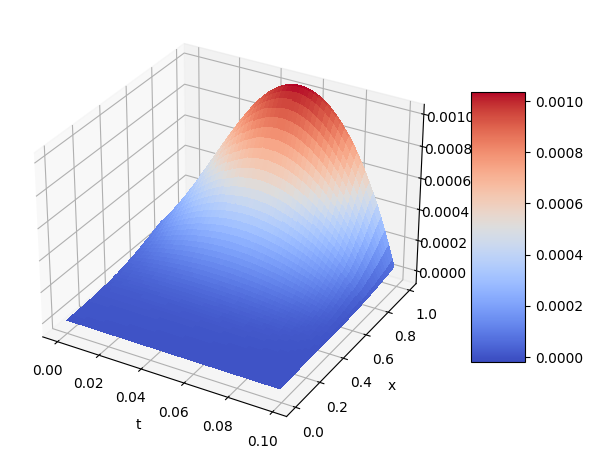

In [23]:
sol.plot2d()

# If alpha is known 

In [116]:
import matplotlib.pyplot as plt
from clspde.solution import lp as l
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

function_list = ['c', 'v']
variable_list = ['t','x']

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)


power = 5
params = {
        'n_dims': 2,
        'dim_sizes': np.array([4, 4]),
        'area_lims': np.array([[0,1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

# def alpha(x):
#     return x[1]**2

# c = 1

def alpha(x):
     return sigma**2/2 *np.pi
    #  return np.cos(np.pi * x)
     #return (x**2)+1

sigma = 0.5

def Bx(x):
        #border condition for x
        # return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))
        return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

def BtI(x):
    #border condition Initial for t
    return int(x[0]==sol.area_lims[0,0])

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]==sol.area_lims[0,1])


def prepare_model(border_weight, colloc_weight, connect_weights, c):
    sol = Solution(**params)

    k1 = connect_weights[0]
    k2 = connect_weights[1]


    # colloc_left_operators = [lp('(d/dt) v + (d/dx)^2 v /2*sigma**2 - alpha( x[1] )**2 * ( 2 * c * ( &c -  x[0] ) ) '),
    #                         lp('(d/dx) v + c * 2*alpha( x[1] )**2')
    #                         ]
    
    # colloc_right_operators = [lp('- alpha( x[1] )**2* ( &c **2 + x[0] ** 2 )'),
    #                           lp('x[0] * alpha( x[1] )**2')
    #                           ]



    # colloc_left_operators = [lp('(d/dt) v + (d/dx)^2 v * sigma**2/2 + alpha( x[1] ) * c * x[0]'),
    #                         lp('(d/dx) v + c * x[0]')
    #                         ]
    
    # colloc_right_operators = [lp('alpha( x[1] )'),
    #                           lp('1')
    #                           ]

    k = 2

    colloc_left_operators = [lp('(d/dt) v + (d/dx)^2 v * sigma**2/2 - c * x[0] * np.pi * sigma**2/2 * np.exp(k*x[1])'),
                            lp('(d/dx) v - c * x[0] * np.exp(k * x[1])')
                            ]
    
    colloc_right_operators = [lp('np.exp(k * x[1])'),
                              lp('0')
                              ]

    colloc_ops = [colloc_left_operators, colloc_right_operators]
        
    small = 1e-5

    
    border_left_operators = [
        lp('Bx(x) * (d/dx) v'),
        lp('BtT(x) * v'),
        # lp('Bx(x) * c'),
    ]
    border_right_operators = [
        lp('Bx(x)* 0'),
        lp('BtT(x) * x[0] * np.cos( x[1] * np.pi )'),
        # lp('Bx(x)* 0'),
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = np.array([
                                [-1, 0.25], [-1, -0.25],
                                [-1, 0.75], [-1, -0.75],
                                
                                [0.25, -1], [0.25, -1],
                                [0.75, -1], [0.75, -1],
                                
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                [1, 1], [1, -1],
                                [-1, 1], [-1, -1],
                                ])


    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)


    for func_num in range(sol.n_funcs):
        connect_left_operators += [
                            lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc), func_num) + k2*np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
                            ]
        connect_right_operators += [
                            lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
                            ]

    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [ ]:
import matplotlib.pyplot as plt
from clspde.solution import lp as l
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

function_list = ['c', 'v']
variable_list = ['t','x']

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)


power = 5
params = {
        'n_dims': 2,
        'dim_sizes': np.array([4, 4]),
        'area_lims': np.array([[0,1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

# def alpha(x):
#     return x[1]**2

# c = 1

def alpha(x):
     return sigma**2/2 *np.pi
    #  return np.cos(np.pi * x)
     #return (x**2)+1

sigma = 0.5

def Bx(x):
        #border condition for x
        # return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))
        return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

def BtI(x):
    #border condition Initial for t
    return int(x[0]==sol.area_lims[0,0])

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]==sol.area_lims[0,1])


def prepare_model(border_weight, colloc_weight, connect_weights, c):
    sol = Solution(**params)

    k1 = connect_weights[0]
    k2 = connect_weights[1]


    # colloc_left_operators = [lp('(d/dt) v + (d/dx)^2 v /2*sigma**2 - alpha( x[1] )**2 * ( 2 * c * ( &c -  x[0] ) ) '),
    #                         lp('(d/dx) v + c * 2*alpha( x[1] )**2')
    #                         ]
    
    # colloc_right_operators = [lp('- alpha( x[1] )**2* ( &c **2 + x[0] ** 2 )'),
    #                           lp('x[0] * alpha( x[1] )**2')
    #                           ]



    # colloc_left_operators = [lp('(d/dt) v + (d/dx)^2 v * sigma**2/2 + alpha( x[1] ) * c * x[0]'),
    #                         lp('(d/dx) v + c * x[0]')
    #                         ]
    
    # colloc_right_operators = [lp('alpha( x[1] )'),
    #                           lp('1')
    #                           ]

    k = 2

    colloc_left_operators = [lp('(d/dt) v + (d/dx)^2 v * sigma**2/2 - c * x[0] * alpha(x[1]) * np.exp(k*x[1])'),
                            lp('(d/dx) v - c * x[0] * np.exp(k * x[1])')
                            ]
    
    colloc_right_operators = [lp('np.exp(k * x[1])'),
                              lp('0')
                              ]

    colloc_ops = [colloc_left_operators, colloc_right_operators]
        
    small = 1e-5

    
    border_left_operators = [
        lp('Bx(x) * (d/dx) v'),
        lp('BtT(x) * v'),
        # lp('Bx(x) * c'),
    ]
    border_right_operators = [
        lp('Bx(x)* 0'),
        lp('BtT(x) * x[0] * np.cos( x[1] * np.pi )'),
        # lp('Bx(x)* 0'),
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = np.array([
                                [-1, 0.25], [-1, -0.25],
                                [-1, 0.75], [-1, -0.75],
                                
                                [0.25, -1], [0.25, -1],
                                [0.75, -1], [0.75, -1],
                                
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                [1, 1], [1, -1],
                                [-1, 1], [-1, -1],
                                ])


    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)


    for func_num in range(sol.n_funcs):
        connect_left_operators += [
                            lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc), func_num) + k2*np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
                            ]
        connect_right_operators += [
                            lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
                            ]

    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [117]:
weights = {'border_weight':100,
            'colloc_weight':1,
            'connect_weights':[1,1]
}

sol, iteration_dict = prepare_model(**weights, c = c)
sol.global_solve(**iteration_dict)

NameError: name 'k' is not defined

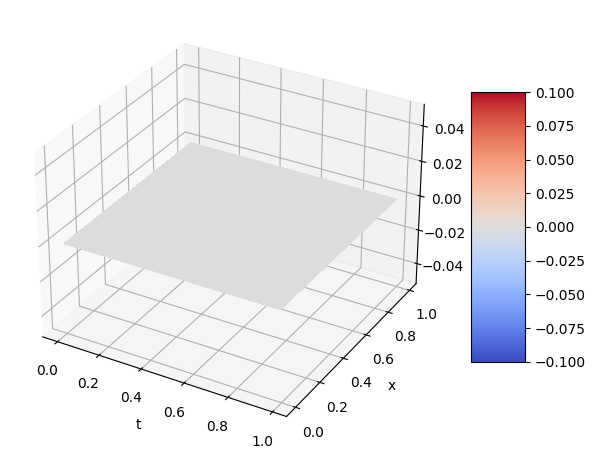

In [118]:
sol.plot2d()

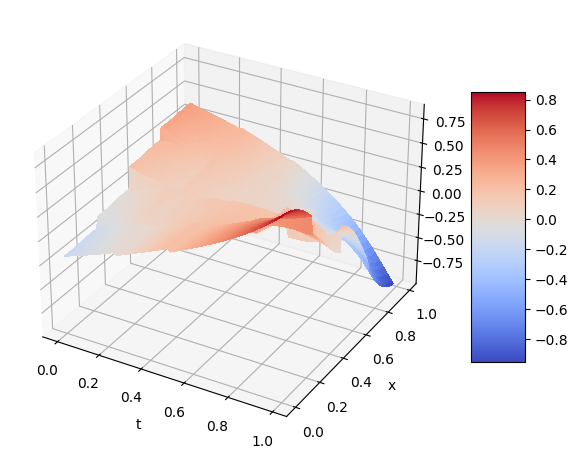

In [115]:
sol.plot2d(func_num=1)

In [72]:
(sigma * np.pi)**2 /2

1.2337005501361697